# JOBSHEET 03: TEKNIK REGRESI GAMBAR

## Praktikum D1: Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)

### 1. Setup & Generator Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models


# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

### 2. “Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

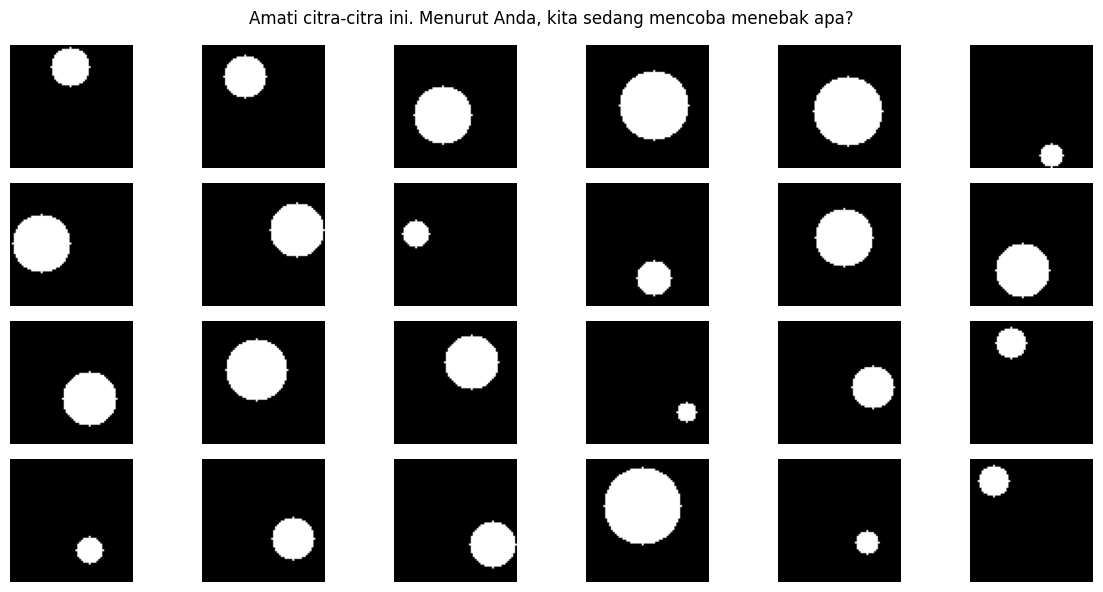

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

### 3. Buka Jawaban — Target yang Ingin Diprediksi

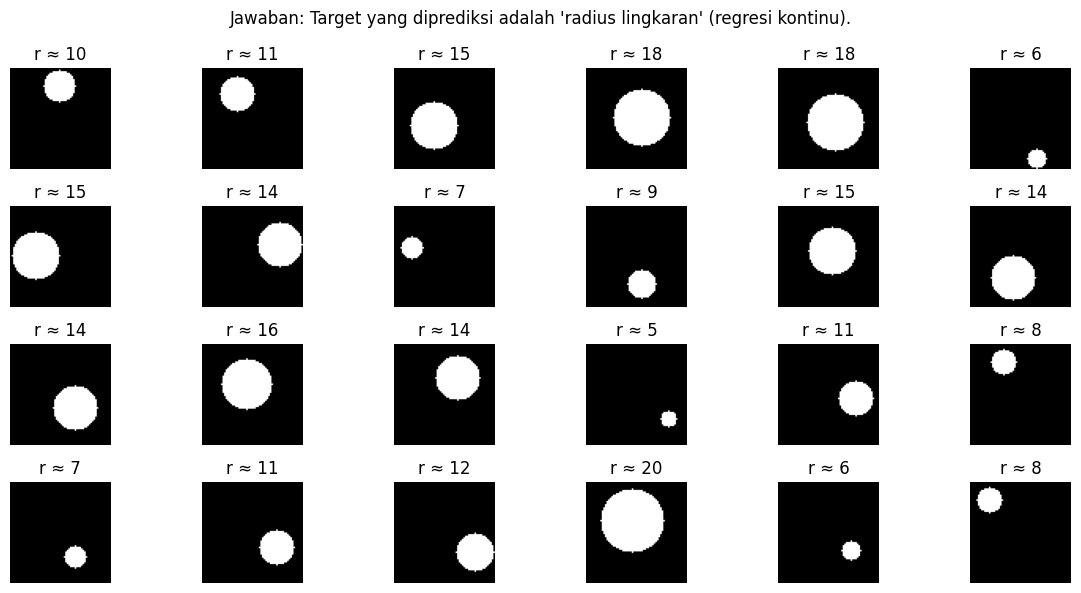

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

### 4. Latih CNN Kecil untuk Memprediksi Radius

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.924 | RMSE=1.156 | R2=0.932


#### Plot history & True vs Predicted:

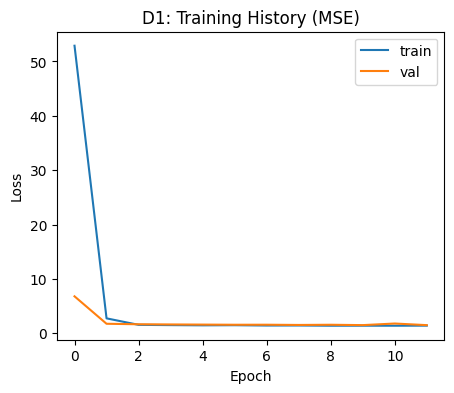

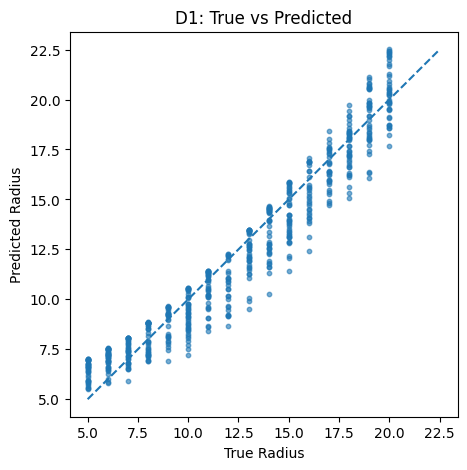

In [ ]:
# Plot loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

### Tantangan Mini (Opsional untuk Mahasiswa)
1. Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R2.
2. Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
3. Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus;
metrik evaluasi apa yang cocok?

=== [Eksperimen 1] Radius Lebih Lebar (8–28) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


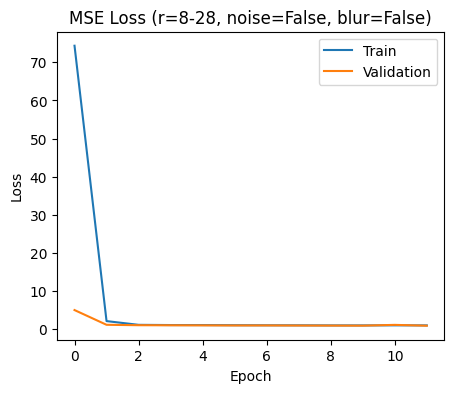

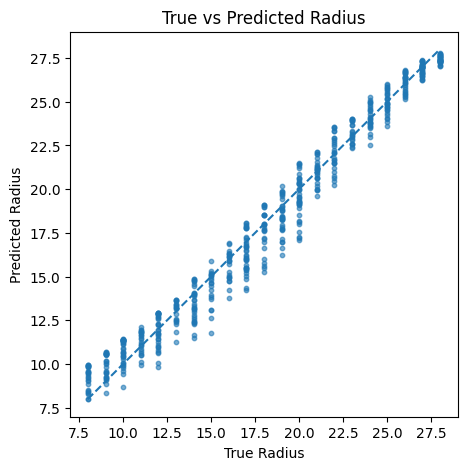

MAE = 0.750 | RMSE = 0.952 | R² = 0.976

=== [Eksperimen 2A] Tambah Gaussian Noise ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


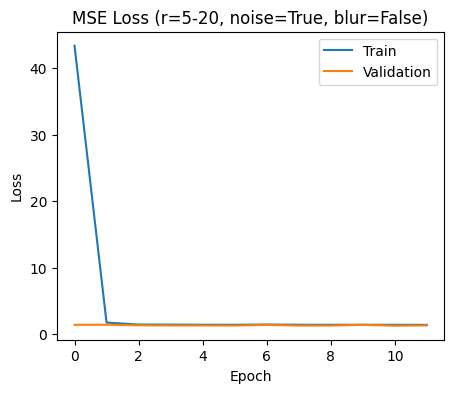

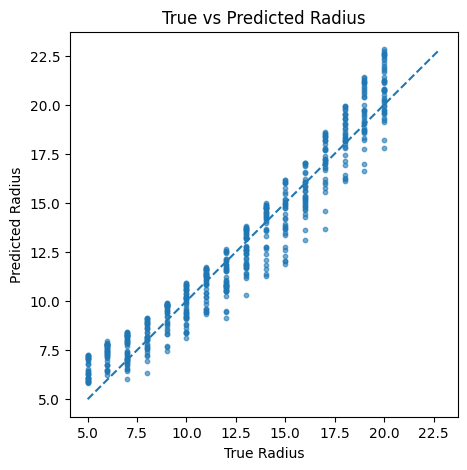

MAE = 0.934 | RMSE = 1.150 | R² = 0.937

=== [Eksperimen 2B] Tambah Gaussian Blur ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


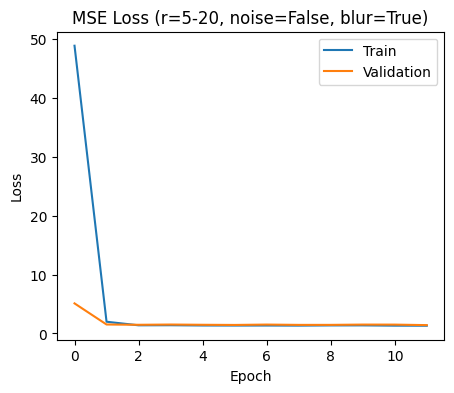

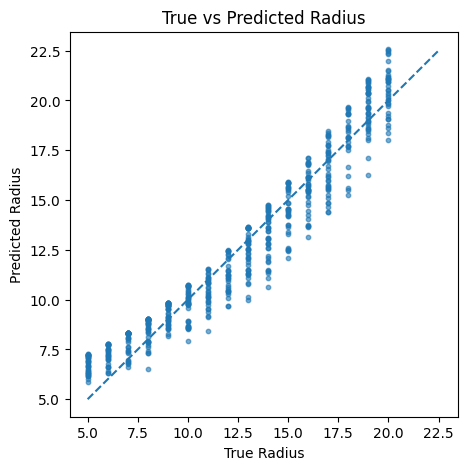

MAE = 0.967 | RMSE = 1.187 | R² = 0.932

=== [Eksperimen 3] Multi-Output Regression [r, cx, cy] ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
MAE → radius=0.73, cx=4.13, cy=3.70
RMSE → radius=0.97, cx=5.26, cy=4.85
R² → radius=0.954, cx=0.782, cy=0.815


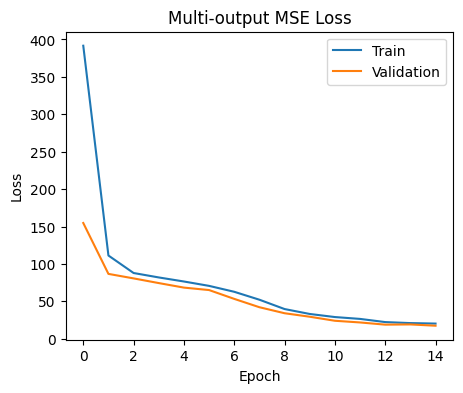

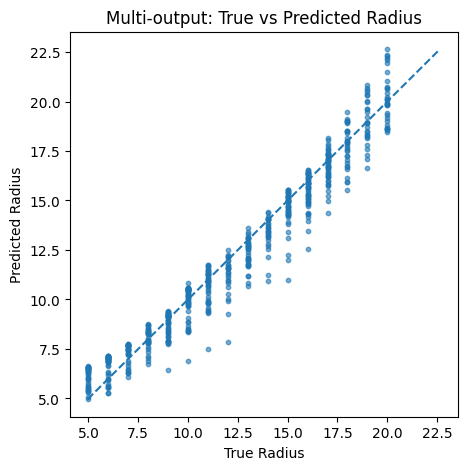


=== 🔍 Rangkuman Hasil Eksperimen ===
1️⃣ Radius Lebar (8–28): MAE=0.750, RMSE=0.952, R²=0.976
2️⃣ Noise: MAE=0.934, RMSE=1.150, R²=0.937
3️⃣ Blur : MAE=0.967, RMSE=1.187, R²=0.932


In [ ]:
# === 📦 Import Library ===
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import layers, models
import tensorflow as tf

# ============================================================
# 🧩 Fungsi Pembuat Data Sintetis (Lingkaran)
# ============================================================
def generate_circle(img_size=64, min_r=5, max_r=20, add_noise=False, add_blur=False):
    """Membuat satu citra lingkaran putih di background hitam"""
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, 255, -1)

    # Tambahkan noise Gaussian
    if add_noise:
        noise = np.random.normal(0, 25, img.shape)
        img = np.clip(img + noise, 0, 255)

    # Tambahkan blur
    if add_blur:
        img = cv2.GaussianBlur(img, (5, 5), 1)

    # Normalisasi dan ubah ke 3 channel
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

# ============================================================
# ⚙️ Fungsi Training Model CNN (Single Output: Radius)
# ============================================================
def train_regresi_radius(min_r=5, max_r=20, add_noise=False, add_blur=False):
    N = 3000
    X, y, _ = zip(*[generate_circle(min_r=min_r, max_r=max_r, add_noise=add_noise, add_blur=add_blur) for _ in range(N)])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model CNN sederhana
    model = models.Sequential([
        layers.Input((64, 64, 3)),
        layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'), layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=12, batch_size=64, verbose=0)

    y_pred = model.predict(X_test).ravel()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    r2 = r2_score(y_test, y_pred)

    # Plot Loss
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"MSE Loss (r={min_r}-{max_r}, noise={add_noise}, blur={add_blur})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot Scatter True vs Predicted
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_pred, s=10, alpha=0.6)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, '--')
    plt.xlabel("True Radius")
    plt.ylabel("Predicted Radius")
    plt.title("True vs Predicted Radius")
    plt.show()

    print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")
    return mae, rmse, r2


# ============================================================
# 🧠 Eksperimen 1: Ubah Rentang Radius (8–28)
# ============================================================
print("=== [Eksperimen 1] Radius Lebih Lebar (8–28) ===")
mae1, rmse1, r21 = train_regresi_radius(min_r=8, max_r=28)

# ============================================================
# 🧠 Eksperimen 2: Tambah Noise & Blur
# ============================================================
print("\n=== [Eksperimen 2A] Tambah Gaussian Noise ===")
mae2, rmse2, r22 = train_regresi_radius(add_noise=True)

print("\n=== [Eksperimen 2B] Tambah Gaussian Blur ===")
mae3, rmse3, r23 = train_regresi_radius(add_blur=True)


# ============================================================
# 🧠 Eksperimen 3: Multi-Output Regression [r, cx, cy]
# ============================================================
print("\n=== [Eksperimen 3] Multi-Output Regression [r, cx, cy] ===")

N = 3000
X, y_r, centers = zip(*[generate_circle() for _ in range(N)])
X = np.array(X, dtype=np.float32)
r = np.array(y_r, dtype=np.float32).reshape(-1, 1)
centers = np.array(centers, dtype=np.float32)
y = np.hstack((r, centers))  # Gabungkan jadi [r, cx, cy]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'), layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=15, batch_size=64, verbose=0)

y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test), axis=0)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2, axis=0))
r2_r = r2_score(y_test[:, 0], y_pred[:, 0])
r2_cx = r2_score(y_test[:, 1], y_pred[:, 1])
r2_cy = r2_score(y_test[:, 2], y_pred[:, 2])

print(f"MAE → radius={mae[0]:.2f}, cx={mae[1]:.2f}, cy={mae[2]:.2f}")
print(f"RMSE → radius={rmse[0]:.2f}, cx={rmse[1]:.2f}, cy={rmse[2]:.2f}")
print(f"R² → radius={r2_r:.3f}, cx={r2_cx:.3f}, cy={r2_cy:.3f}")

# Plot Loss Multi-output
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Multi-output MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter radius prediksi
plt.figure(figsize=(5, 5))
plt.scatter(y_test[:, 0], y_pred[:, 0], s=10, alpha=0.6)
lims = [min(y_test[:, 0].min(), y_pred[:, 0].min()), max(y_test[:, 0].max(), y_pred[:, 0].max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("Multi-output: True vs Predicted Radius")
plt.show()

# ============================================================
# 📊 Rangkuman Hasil
# ============================================================
print("\n=== 🔍 Rangkuman Hasil Eksperimen ===")
print(f"1️⃣ Radius Lebar (8–28): MAE={mae1:.3f}, RMSE={rmse1:.3f}, R²={r21:.3f}")
print(f"2️⃣ Noise: MAE={mae2:.3f}, RMSE={rmse2:.3f}, R²={r22:.3f}")
print(f"3️⃣ Blur : MAE={mae3:.3f}, RMSE={rmse3:.3f}, R²={r23:.3f}")

## Praktikum D2: Menebak Umur Manusia dari Foto Wajah (UTKFace)

### Langkah 1: Membuat Akun Kaggle dan Mengunduh kaggle.json

Ikuti langkah berikut:
1. Buka situs https://www.kaggle.com
2. Daftar menggunakan email Google atau GitHub.
3. Setelah login, klik profil di kanan atas → pilih “Account”.
4. Gulir ke bawah ke bagian API → klik “Create New API Token”.
5. File bernama kaggle.json akan otomatis terunduh ke komputer Anda.

### Langkah 2: Mengunggah kaggle.json ke Colab

In [ ]:
# Jalankan ini di awal notebook
from google.colab import files

files.upload()  # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cahyogadhang","key":"f92fe4e4405bf4ffe95c7c7cae9eed4b"}'}

In [ ]:
import os
import shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


### Langkah 3: Mengunduh Dataset UTKFace dari Kaggle

In [ ]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


### Langkah 4: Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


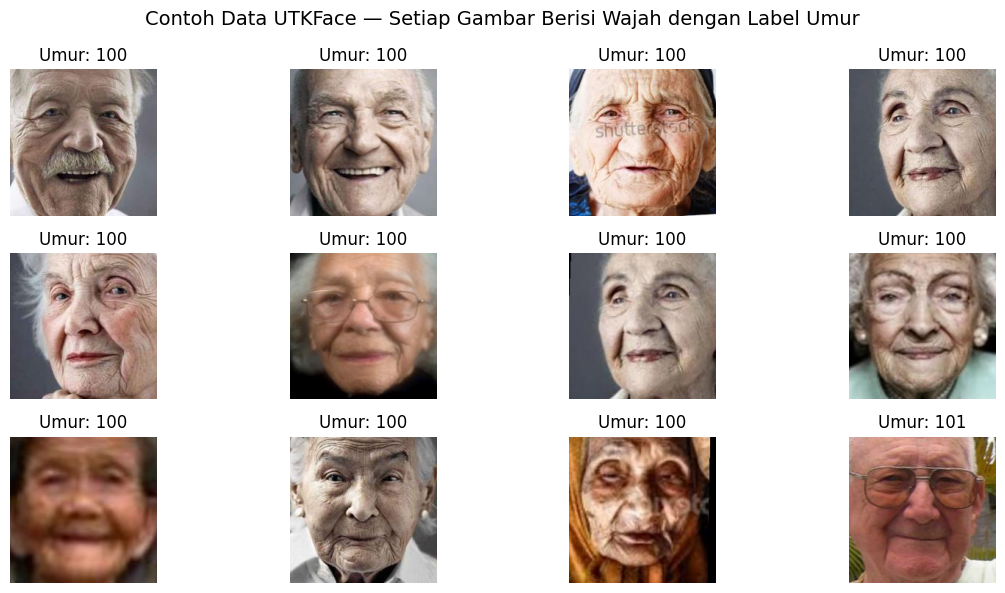

In [ ]:
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

### Langkah 5: Siapkan Dataset untuk Model

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


### Langkah 6: Membangun Model dengan Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Langkah 7: Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 56s 131ms/step - loss: 356.4647 - mae: 13.8829 - val_loss: 160.0213 - val_mae: 9.5988 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - loss: 157.3050 - mae: 9.3185 - val_loss: 147.9934 - val_mae: 9.1608 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 145.0244 - mae: 8.8804 - val_loss: 143.4893 - val_mae: 8.9666 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 141.2755 - mae: 8.7439 - val_loss: 141.4094 - val_mae: 8.8846 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 140.9320 - mae: 8.7105 - val_loss: 139.1287 - val_mae: 8.7656 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 135.4465 - mae: 8.5292 - val_loss: 139.7682 - val_mae: 8.8310 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 137.2628 - mae: 8.5579 - val_loss: 136.9079 - va

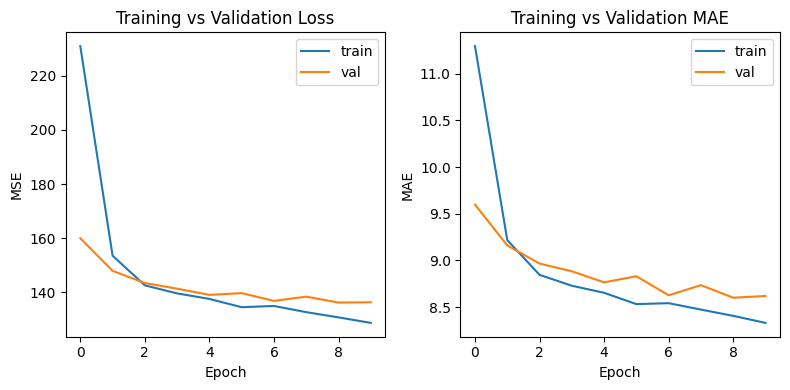

In [ ]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

### Langkah 8: Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - loss: 192.0698 - mae: 10.1595 - val_loss: 149.4282 - val_mae: 8.8660 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 79.4585 - mae: 6.6209 - val_loss: 120.5363 - val_mae: 7.9388 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 51.6199 - mae: 5.3683 - val_loss: 105.9483 - val_mae: 7.6765 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 37.0522 - mae: 4.6008 - val_loss: 101.1141 - val_mae: 7.2954 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 29.6341 - mae: 4.0943 - val_loss: 98.0680 - val_mae: 7.1881 - learning_rate: 1.0000e-04


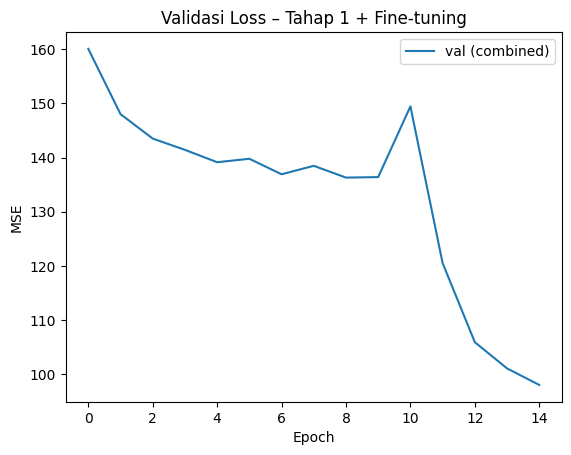

In [ ]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

### Langkah 9: Evaluasi Akhir (MAE, RMSE, R2)

MAE = 7.19 tahun
RMSE = 9.90 tahun
R2 = 0.753


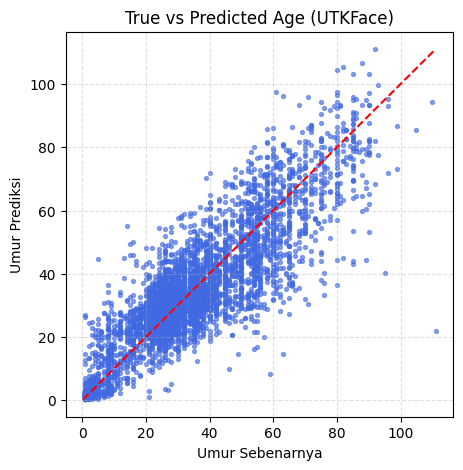

In [ ]:
from math import sqrt

y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel() for batch in test_ds
])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### Langkah 10: Melihat Contoh Prediksi Nyata

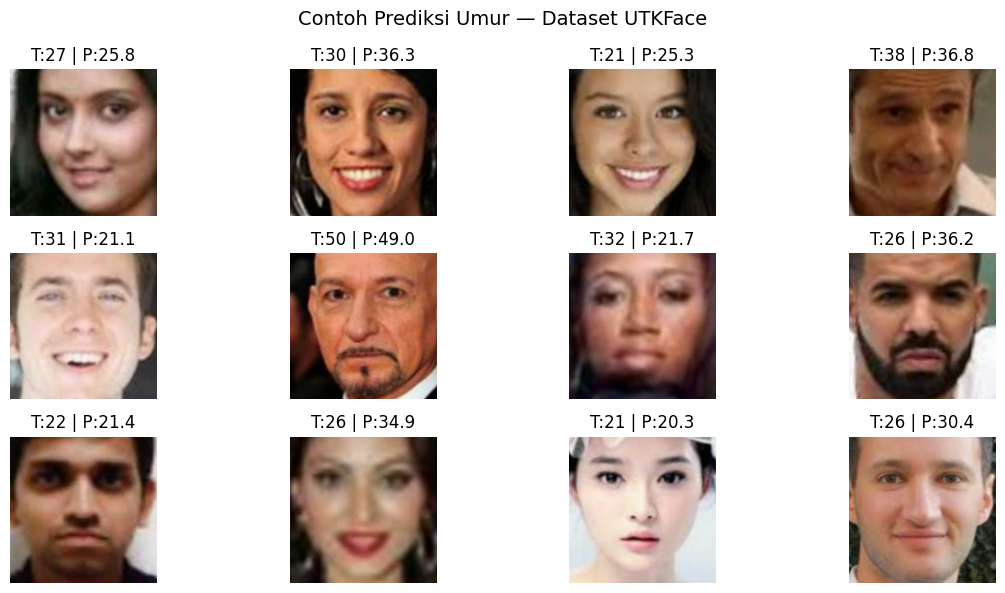

In [ ]:
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

### Tantangan Mini (Opsional)
1. Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2. Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3. Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4. Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?

🔹 Memuat dataset UTKFace...
Total gambar ditemukan: 23708

🔹 Menyiapkan data augmentasi...

🔹 Membangun model MobileNetV2...

🔹 Menyiapkan optimizer dan scheduler...

🚀 Training dimulai...

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 163s 512ms/step - loss: 475.8336 - mae: 16.8035 - val_loss: 291.3834 - val_mae: 13.2453
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 142s 478ms/step - loss: 397.0763 - mae: 15.2683 - val_loss: 266.1570 - val_mae: 12.0612
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 141s 475ms/step - loss: 398.3789 - mae: 15.2911 - val_loss: 246.5479 - val_mae: 11.6416
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 142s 477ms/step - loss: 393.9107 - mae: 15.2296 - val_loss: 234.4810 - val_mae: 11.6244
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 143s 481ms/step - loss: 389.1415 - mae: 15.1340 - val_loss: 227.0563 - val_mae: 11.5689
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 141s 475ms/step - loss: 390.9543 - mae: 15.1947 - val_loss: 240.6650 - val_mae: 12.5078
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14

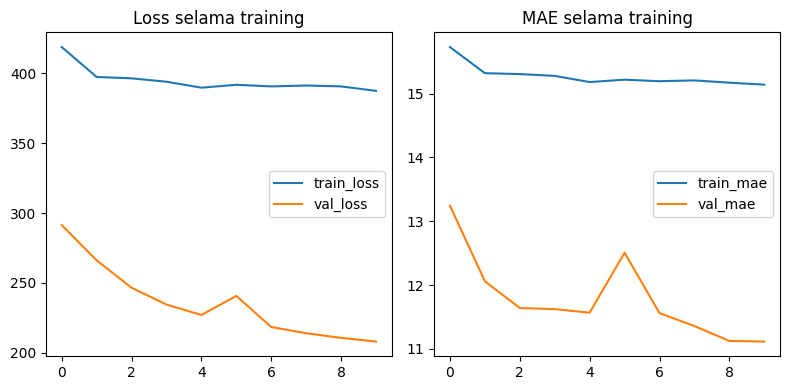


🔹 Analisis MAE per kelompok umur...
0–10: 13.19 tahun
11–20: 12.83 tahun
21–40: 7.70 tahun
41–60: 10.28 tahun
61+: 24.77 tahun


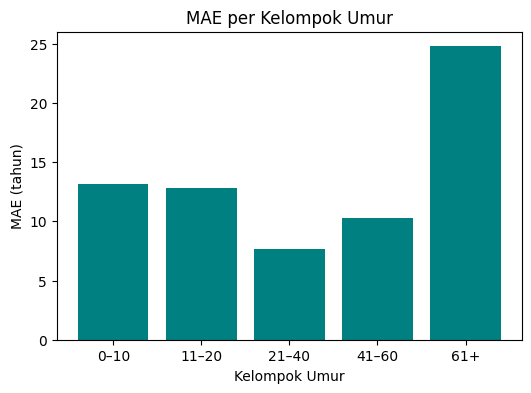


🔹 Uji model pada foto wajah sendiri


Saving Gambar WhatsApp 2025-10-14 pukul 18.07.01_abb40773.jpg to Gambar WhatsApp 2025-10-14 pukul 18.07.01_abb40773.jpg


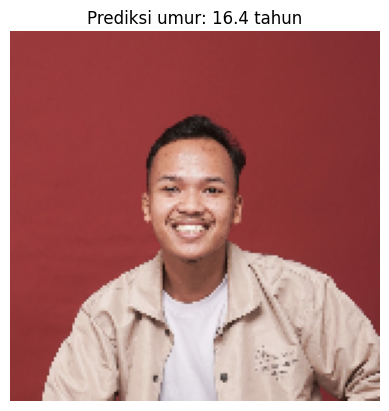

📷 File: Gambar WhatsApp 2025-10-14 pukul 18.07.01_abb40773.jpg → Prediksi umur: 16.4 tahun

✅ Selesai! Bandingkan hasil MAE & grafik untuk analisis performa.


In [ ]:
import os, glob
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# --- 1. Persiapan Dataset -------------------------------------------------
print("🔹 Memuat dataset UTKFace...")
files = glob.glob("/content/utk/UTKFace/*.jpg")
print(f"Total gambar ditemukan: {len(files)}")

def parse_age(filename):
    return int(os.path.basename(filename).split('_')[0])

ages = np.array([parse_age(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
BATCH_SIZE = 64

def load_image(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label


# --- 2. Data Augmentation -------------------------------------------------
print("\n🔹 Menyiapkan data augmentasi...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomZoom(0.2),
])

def load_aug(fp, label):
    img, label = load_image(fp, label)
    img = data_augmentation(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# --- 3. Membangun Model (MobileNetV2 + Dense Layer) -----------------------
print("\n🔹 Membangun model MobileNetV2...")

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # freeze feature extractor

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# --- 4. Learning Rate Scheduler ------------------------------------------
print("\n🔹 Menyiapkan optimizer dan scheduler...")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=200,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# --- 5. Training Model ----------------------------------------------------
print("\n🚀 Training dimulai...\n")
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


# --- 6. Evaluasi Model ----------------------------------------------------
print("\n🔹 Evaluasi model...")
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print("\n📊 Hasil Evaluasi Keseluruhan")
print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot hasil training
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss selama training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title("MAE selama training")
plt.legend()
plt.tight_layout()
plt.show()


# --- 7. Analisis Error per Kelompok Umur ---------------------------------
print("\n🔹 Analisis MAE per kelompok umur...")
groups = {
    "0–10": (0, 10),
    "11–20": (11, 20),
    "21–40": (21, 40),
    "41–60": (41, 60),
    "61+": (61, 116)
}

group_mae = {}
for name, (low, high) in groups.items():
    mask = (y_test >= low) & (y_test <= high)
    if np.sum(mask) > 0:
        group_mae[name] = mean_absolute_error(y_test[mask], y_pred[mask])
        print(f"{name}: {group_mae[name]:.2f} tahun")

plt.figure(figsize=(6,4))
plt.bar(group_mae.keys(), group_mae.values(), color='teal')
plt.title("MAE per Kelompok Umur")
plt.ylabel("MAE (tahun)")
plt.xlabel("Kelompok Umur")
plt.show()


# --- 8. Uji pada Wajah Sendiri -------------------------------------------
print("\n🔹 Uji model pada foto wajah sendiri")

from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    pred = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.imshow(img.numpy())
    plt.title(f"Prediksi umur: {pred:.1f} tahun")
    plt.axis("off")
    plt.show()

    print(f"📷 File: {fname} → Prediksi umur: {pred:.1f} tahun")

print("\n✅ Selesai! Bandingkan hasil MAE & grafik untuk analisis performa.")

## Praktikum D3: Menilai “Kepopuleran Hewan Peliharaan” dari Foto

### Langkah 1: Menyiapkan Kaggle API
1. Buka situs https://www.kaggle.com
2. Login dengan akun Google.
3. Klik profil → Account → gulir ke bawah ke bagian API.
4. Klik Create New API Token.
File kaggle.json akan otomatis terunduh.
5. Unggah file tersebut ke Colab dengan:

In [ ]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


### Langkah 2: Mengunduh dan Mengekstrak Dataset

In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


### Langkah 3: Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

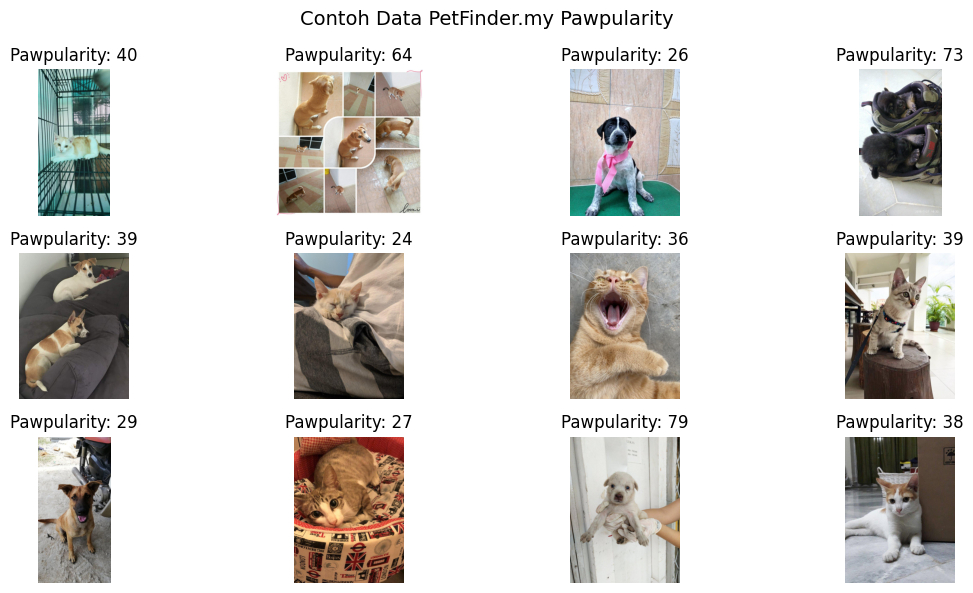

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

### Langkah 4: Persiapan Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


### Langkah 5: Membangun Model (EfficientNetB0)

In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Langkah 6: Melatih Model

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 107s 537ms/step - loss: 810.1586 - mae: 21.6151 - val_loss: 480.7828 - val_mae: 16.2504 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - loss: 427.3945 - mae: 15.3452 - val_loss: 429.4543 - val_mae: 15.3686 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - loss: 391.5483 - mae: 14.7240 - val_loss: 403.4098 - val_mae: 14.9454 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 377.2386 - mae: 14.4705 - val_loss: 389.4514 - val_mae: 14.3879 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - loss: 356.6776 - mae: 14.0965 - val_loss: 381.4951 - val_mae: 14.4986 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - loss: 342.0487 - mae: 13.6735 - val_loss: 376.0786 - val_mae: 14.3444 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - loss: 343.3226 - mae: 13.8126 - val_

### Langkah 7: Melihat Proses Belajar

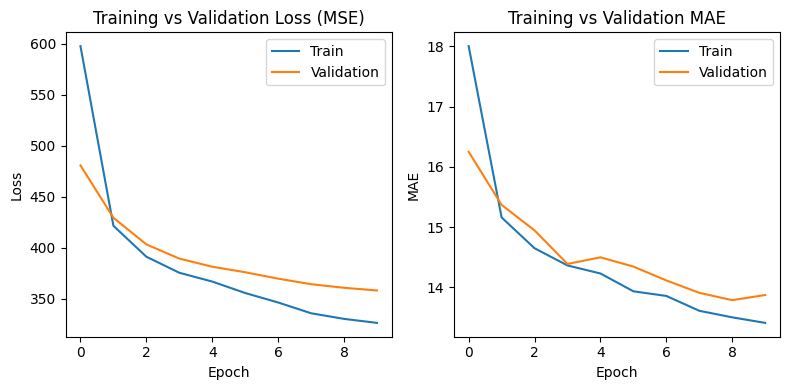

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

### Langkah 8: Evaluasi Model

MAE = 13.87
RMSE = 18.93
R2 = 0.190


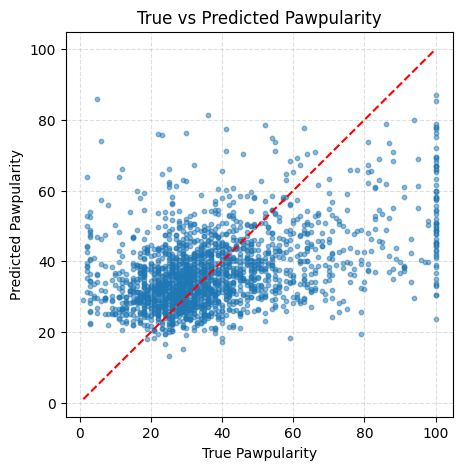

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R2 = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### Langkah 9: Melihat Contoh Prediksi

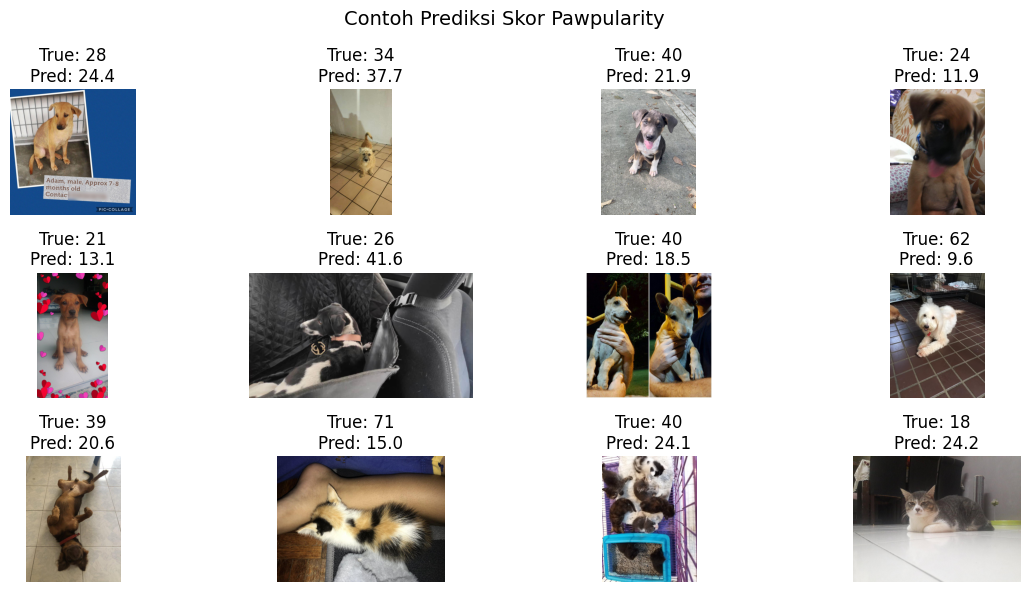

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

### Tantangan Mini

#### 1. Coba tambahkan data augmentation agar model tidak bosan dengan pola yang sama.

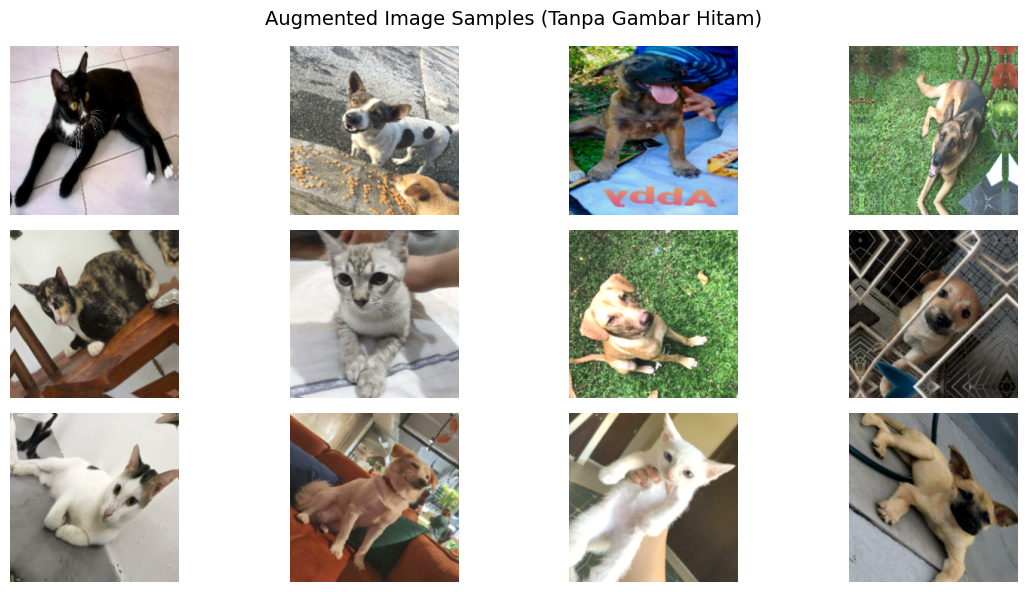

✅ Dataset augmented siap. IMG_SIZE=224, Batch=64


In [ ]:
# ====================================================
# 🧩 1️⃣ Data Augmentation — Random Flip, Rotation, Zoom, Brightness
# ====================================================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ------------------------------------------
# Set ukuran gambar (konsisten ke semua model)
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# ------------------------------------------
# Split ulang data frame (kalau belum)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# ------------------------------------------
# Pipeline augmentasi (bekerja di skala 0–255)
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
], name="data_augmentation")

# ------------------------------------------
# Fungsi untuk load + augment + normalisasi gambar
def load_image_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # augmentasi (masih di skala 0–255)
    img = tf.cast(img, tf.float32)
    img = augment(img)

    # jaga agar nilai tetap valid [0–255]
    img = tf.clip_by_value(img, 0.0, 255.0)

    # normalisasi ke [0–1]
    img = img / 255.0
    return img, tf.cast(label, tf.float32)

# ------------------------------------------
# Dataset dengan augmentasi
train_ds_aug = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image_aug, num_parallel_calls=AUTOTUNE)
    .shuffle(4096)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(lambda p, y: load_image_aug(p, y), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# ------------------------------------------
# 🔍 Cek hasil augmentasi
sample_imgs = next(iter(train_ds_aug.take(1)))[0]

plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_imgs[i].numpy())
    plt.axis('off')
plt.suptitle("Augmented Image Samples (Tanpa Gambar Hitam)", fontsize=14)
plt.tight_layout()
plt.show()

print(f"✅ Dataset augmented siap. IMG_SIZE={IMG_SIZE}, Batch={BATCH_SIZE}")

#### 2. Gunakan EfficientNetB3 atau ResNet50, lalu bandingkan hasilnya.

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - loss: 866.8929 - mae: 22.4101 - val_loss: 513.7020 - val_mae: 16.5392
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 141s 738ms/step - loss: 458.1313 - mae: 15.9303 - val_loss: 453.3448 - val_mae: 15.9744
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 156s 843ms/step - loss: 421.2608 - mae: 15.3204 - val_loss: 421.7191 - val_mae: 14.9915
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 143s 741ms/step - loss: 402.8353 - mae: 14.9199 - val_loss: 404.3784 - val_mae: 15.0184
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 546s 4s/step - loss: 386.1661 - mae: 14.5829 - val_loss: 399.9132 - val_mae: 14.4752
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 178s 888ms/step - loss: 568.2738 - mae: 17.7723 - val_loss: 406.1843 - val_mae: 15.0895
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 740ms/step - loss: 374.4334 - mae: 14.3208 - val_loss: 399.4684 - val_mae: 14.3993
Epoch 3/5
124/1

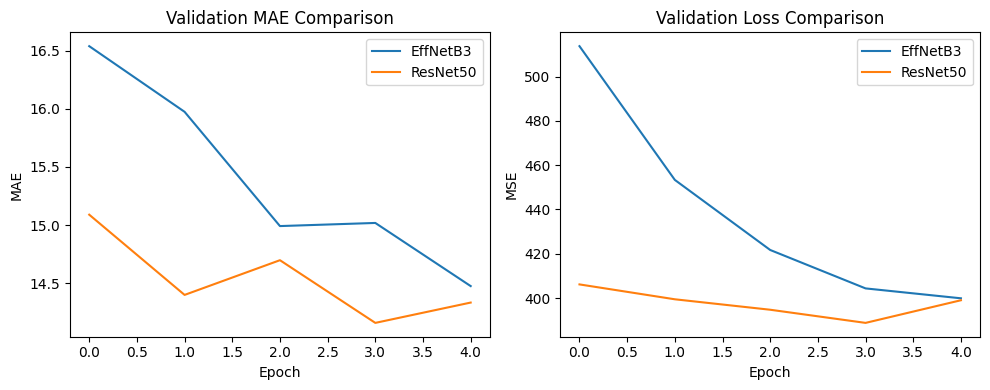

In [ ]:
# ====================================================
# 🧩 2️⃣ EfficientNetB3 vs ResNet50 (Fixed & Optimized)
# ====================================================
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB3, ResNet50
import matplotlib.pyplot as plt
import numpy as np
import random

# Set seed biar hasil konsisten
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def build_model(backbone='efficientnetb3'):
    if backbone == 'efficientnetb3':
        base = EfficientNetB3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
        preprocess = tf.keras.applications.efficientnet.preprocess_input
    else:
        base = ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
        preprocess = tf.keras.applications.resnet.preprocess_input

    base.trainable = False
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = preprocess(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train EfficientNetB3
model_b3 = build_model('efficientnetb3')
history_b3 = model_b3.fit(train_ds_aug, validation_data=val_ds, epochs=5, verbose=1)

# Train ResNet50
model_res = build_model('resnet')
history_res = model_res.fit(train_ds_aug, validation_data=val_ds, epochs=5, verbose=1)

# 🔍 Bandingkan hasil
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_b3.history['val_mae'], label='EffNetB3')
plt.plot(history_res.history['val_mae'], label='ResNet50')
plt.title("Validation MAE Comparison")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_b3.history['val_loss'], label='EffNetB3')
plt.plot(history_res.history['val_loss'], label='ResNet50')
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend()
plt.tight_layout()
plt.show()

#### 3. Buat eksperimen kecil: pisahkan anjing vs kucing — apakah model bias ke salah satu spesies?

🐶 Dog MAE: 14.27
🐱 Cat MAE: 14.89


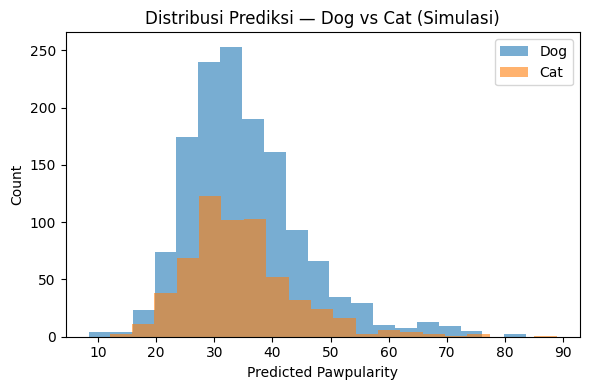

In [ ]:
# ====================================================
# 🧩 3️⃣ Eksperimen Bias — Anjing vs Kucing
# ====================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Hapus kolom 'species' yang mungkin tersisa dari percobaan sebelumnya
if 'species' in val_df.columns:
    val_df = val_df.drop(columns=['species'])

# Simulasikan kolom species secara acak (untuk demonstrasi)
np.random.seed(42)  # agar hasil sama tiap dijalankan
simulated_species = np.random.choice(['dog', 'cat'], size=len(val_df), p=[0.7, 0.3])
val_df['species'] = simulated_species

# Pastikan model EfficientNetB3 sudah ada dari instruksi ke-2
try:
    # Prediksi Pawpularity
    y_pred = np.concatenate([
        model_b3.predict(batch[0], verbose=0).ravel()
        for batch in val_ds
    ])
    val_df['pred'] = y_pred

    # Hitung MAE per spesies
    dog_mae = mean_absolute_error(
        val_df[val_df['species'] == 'dog']['Pawpularity'],
        val_df[val_df['species'] == 'dog']['pred']
    )
    cat_mae = mean_absolute_error(
        val_df[val_df['species'] == 'cat']['Pawpularity'],
        val_df[val_df['species'] == 'cat']['pred']
    )

    print(f"🐶 Dog MAE: {dog_mae:.2f}")
    print(f"🐱 Cat MAE: {cat_mae:.2f}")

    # 🔍 Visualisasi distribusi hasil prediksi
    plt.figure(figsize=(6,4))
    plt.hist(val_df[val_df['species'] == 'dog']['pred'], bins=20, alpha=0.6, label='Dog')
    plt.hist(val_df[val_df['species'] == 'cat']['pred'], bins=20, alpha=0.6, label='Cat')
    plt.xlabel("Predicted Pawpularity")
    plt.ylabel("Count")
    plt.title("Distribusi Prediksi — Dog vs Cat (Simulasi)")
    plt.legend()
    plt.tight_layout()
    plt.show()

except NameError:
    print("❌ Model EfficientNetB3 (model_b3) belum ditemukan. Jalankan dulu instruksi ke-2.")

#### 4. Tambahkan fitur non-visual (misal brightness rata-rata) ke model regresi.

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 224, 224,  │          0 │ input_layer_38[0… │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ multiply_9[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1281)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 256)       │    328,192 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 64)        │     16,448 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 1)         │         65 │ dense_48[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,394,276 (16.76 MB)

 Trainable params: 344,705 (1.31 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
    124/Unknown 56s 276ms/step - loss: 886.1252 - mae: 22.4915

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


124/124 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - loss: 883.7673 - mae: 22.4544 - val_loss: 417.9147 - val_mae: 15.1299
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 285ms/step - loss: 389.9729 - mae: 14.6168 - val_loss: 372.0134 - val_mae: 14.2917
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 291ms/step - loss: 354.1616 - mae: 13.9317 - val_loss: 357.7415 - val_mae: 13.9760
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 414ms/step - loss: 332.7290 - mae: 13.5532 - val_loss: 352.4098 - val_mae: 13.7694
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - loss: 312.9746 - mae: 13.1734 - val_loss: 350.8864 - val_mae: 13.8026


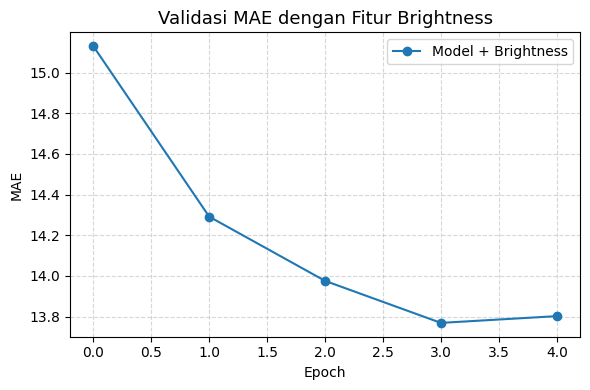

In [ ]:
# ====================================================
# 🧩 4️⃣ Fitur Tambahan — Integrasi Brightness dengan Model Gambar
# ====================================================
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# --- 1️⃣ Hitung Fitur Brightness untuk Tiap Gambar ---
def hitung_brightness(path):
    """Hitung rata-rata kecerahan gambar (0-1)."""
    with Image.open(path).convert("L") as img_gray:
        nilai = np.mean(img_gray)
    return nilai / 255.0

# Tambahkan kolom brightness ke dataframe utama
df['brightness'] = df['path'].apply(hitung_brightness)

# --- 2️⃣ Split Data Train / Validation ---
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# --- 3️⃣ Pipeline Dataset (gabungkan gambar + fitur numerik) ---
def parse_data(path, label, bright):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, (tf.cast(label, tf.float32), tf.cast(bright, tf.float32))

train_ds = (
    tf.data.Dataset.from_tensor_slices(
        (train_df['path'], train_df['Pawpularity'], train_df['brightness'])
    )
    .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices(
        (val_df['path'], val_df['Pawpularity'], val_df['brightness'])
    )
    .map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# --- 4️⃣ Arsitektur Model Multimodal (Gambar + Brightness) ---
input_img = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_num = tf.keras.Input(shape=(1,))

# Gunakan backbone EfficientNetB0 (transfer learning)
base = tf.keras.applications.EfficientNetB0(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet"
)
base.trainable = False

x = tf.keras.applications.efficientnet.preprocess_input(input_img * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# Gabungkan hasil ekstraksi visual dengan fitur brightness
x = layers.Concatenate()([x, input_num])
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(1)(x)

model_brightness = tf.keras.Model([input_img, input_num], output)
model_brightness.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_brightness.summary()

# --- 5️⃣ Generator Dataset untuk Input Ganda ---
def generator(ds):
    for img, (label, bright) in ds:
        yield (img, bright), label

train_gen = tf.data.Dataset.from_generator(
    lambda: generator(train_ds),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    ),
)

val_gen = tf.data.Dataset.from_generator(
    lambda: generator(val_ds),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
    ),
)

# --- 6️⃣ Latih Model ---
history_brightness = model_brightness.fit(
    train_gen, validation_data=val_gen, epochs=5, verbose=1
)

# --- 7️⃣ Visualisasi Hasil Validasi ---
plt.figure(figsize=(6, 4))
plt.plot(history_brightness.history["val_mae"], label="Model + Brightness", marker="o")
plt.title("Validasi MAE dengan Fitur Brightness", fontsize=13)
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Penugasan

## Gunakan foto pribadi untuk menampilkan ujicoba prediksi usia

✅ Library berhasil diimpor.
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Total gambar ditemukan: 23708
Dataset shape: (5000, 64, 64, 3), Label shape: (5000,)
✅ Model CNN siap dilatih.


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 23.6565 - mae: 23.6565 - val_loss: 16.1429 - val_mae: 16.1429
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2455 - mae: 16.2455 - val_loss: 15.5546 - val_mae: 15.5546
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.7258 - mae: 15.7258 - val_loss: 15.2205 - val_mae: 15.2205
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4810 - mae: 15.4810 - val_loss: 14.9855 - val_mae: 14.9855
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.2923 - mae: 15.2923 - val_loss: 15.3854 - val_mae: 15.3854
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.2324 - mae: 15.2324 - val_loss: 14.9190 - val_mae: 14.9190
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.1360 - mae: 15.1360 - val_loss: 14.8411 - val_mae: 14.8411
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 14.9262 - mae: 14.9262 - val_loss: 14.9308 - val_mae: 14.9308
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━

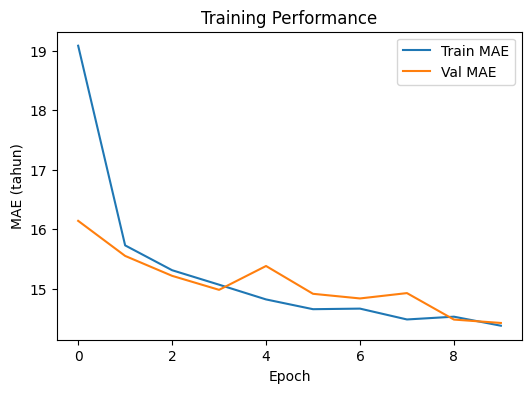

📊 MAE pada data test: 14.43 tahun
✅ Model disimpan sebagai age_model.h5

🧍‍♂️ PREDIKSI UMUR DARI FOTO PRIBADI
📸 Silakan upload 1 atau beberapa foto wajah kamu...


Saving Gambar WhatsApp 2025-10-14 pukul 18.07.01_abb40773.jpg to Gambar WhatsApp 2025-10-14 pukul 18.07.01_abb40773 (1).jpg


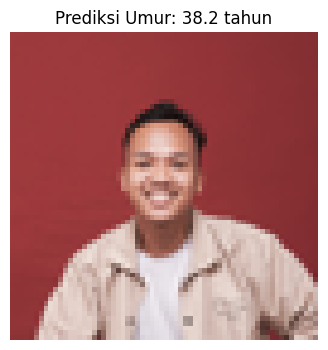

📷 Gambar WhatsApp 2025-10-14 pukul 18.07.01_abb40773 (1).jpg: diprediksi berumur 38.2 tahun.


In [ ]:
# ====================================================
# 🧩 Prediksi Umur dari Wajah (UTKFace + Foto Pribadi)
# ====================================================

# ========== 1️⃣ IMPORT & SETUP ==========
import os, glob, io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import files

print("✅ Library berhasil diimpor.")

# ========== 2️⃣ DOWNLOAD DATASET ==========
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -qo /content/utkface-new.zip -d /content/utk/

dataset_files = glob.glob("/content/utk/UTKFace/*.jpg")
print(f"Total gambar ditemukan: {len(dataset_files)}")

# ========== 3️⃣ PREPROCESSING ==========
IMG_SIZE = 64

def load_data(files):
    X, y = [], []
    for f in files:
        try:
            age = int(os.path.basename(f).split("_")[0])
            img = Image.open(f).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
            X.append(np.array(img) / 255.0)
            y.append(age)
        except:
            continue
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Ambil sebagian agar cepat
if len(dataset_files) > 0:
    X, y = load_data(dataset_files[:5000])
    print(f"Dataset shape: {X.shape}, Label shape: {y.shape}")

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ========== 4️⃣ BANGUN MODEL CNN ==========
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    print("✅ Model CNN siap dilatih.")
    model.summary()

    # ========== 5️⃣ TRAINING ==========
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=64,
        verbose=1
    )

    # Visualisasi training
    plt.figure(figsize=(6,4))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE (tahun)')
    plt.legend()
    plt.title("Training Performance")
    plt.show()

    # ========== 6️⃣ EVALUASI ==========
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"📊 MAE pada data test: {test_mae:.2f} tahun")

    model.save("age_model.h5")
    print("✅ Model disimpan sebagai age_model.h5")

    # ========== 7️⃣ PREDIKSI FOTO PRIBADI ==========
    print("\n" + "="*60)
    print("🧍‍♂️ PREDIKSI UMUR DARI FOTO PRIBADI")
    print("="*60)
    print("📸 Silakan upload 1 atau beberapa foto wajah kamu...")

    uploaded = files.upload()

    def preprocess_image(img_bytes):
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        img_arr = np.array(img_resized, dtype=np.float32) / 255.0
        return img_resized, tf.expand_dims(img_arr, 0)

    for fname, img_bytes in uploaded.items():
        img_resized, img_tensor = preprocess_image(img_bytes)
        pred_age = model.predict(img_tensor, verbose=0).ravel()[0]

        plt.figure(figsize=(4,4))
        plt.imshow(img_resized)
        plt.title(f"Prediksi Umur: {pred_age:.1f} tahun", fontsize=12)
        plt.axis("off")
        plt.show()

        print(f"📷 {fname}: diprediksi berumur {pred_age:.1f} tahun.")

else:
    print("❌ Tidak ada file gambar yang ditemukan. Pastikan dataset berhasil diunduh dan diekstrak.")

## Gunakan foto pribadi (atau hewan peliharaan sendiri) dan uji model Pawpularity

✅ Libraries imported successfully.
✅ Dataset ready — 124 training batches, 31 validation batches.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 128s 662ms/step - loss: 827.7392 - mae: 21.7434 - val_loss: 474.3954 - val_mae: 16.0750 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 207ms/step - loss: 431.2178 - mae: 15.3847 - val_loss: 425.2025 - val_mae: 15.2338 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - loss: 377.5997 - mae: 14.4242 - val_loss: 405.9191 - val_mae: 14.6308 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 369.1270 - mae: 14.2235 - val_loss: 390.9618 - val_mae: 14.7286 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - loss: 352.3583 - mae: 13.8940 - val_loss: 381.6291 - val_mae: 14.4631 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 193ms/step - loss: 345.3534 - mae: 13.7891 - val_loss: 373.9743 - val_mae: 14.2744 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - loss: 343.2417 - mae: 13.7601 - val_

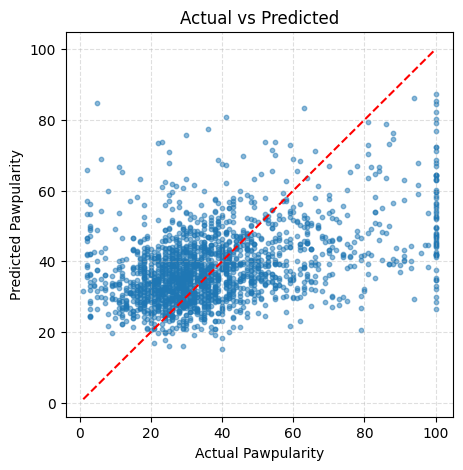

📸 Upload 1 atau beberapa foto hewan peliharaan kamu...


Saving Gambar WhatsApp 2025-10-14 pukul 20.25.31_baf5e87f.jpg to Gambar WhatsApp 2025-10-14 pukul 20.25.31_baf5e87f.jpg


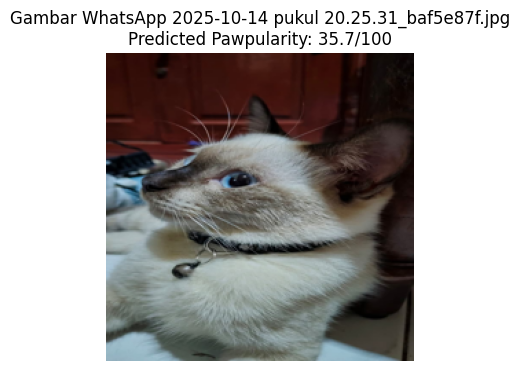

✅ Semua foto berhasil diprediksi oleh model Pawpularity!


In [ ]:
# ====================================================
# 🐾 Pawpularity Model — Test with Personal Pet Photos
# ====================================================

# ========== 0️⃣ Import Library ==========
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
from google.colab import files
import io

print("✅ Libraries imported successfully.")

# ========== 1️⃣ Load Dataset Pawpularity ==========
df = pd.read_csv('/content/paw/train.csv')
df['img_path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

IMG_SIZE = 224

# Split dataset
train_dataset, val_dataset = train_test_split(df, test_size=0.2, random_state=42)

def preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_dataset['img_path'], train_dataset['Pawpularity']))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4000)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((val_dataset['img_path'], val_dataset['Pawpularity']))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"✅ Dataset ready — {len(train_dataset)} training batches, {len(val_dataset)} validation batches.")

# ========== 2️⃣ Build EfficientNetB0 Model ==========
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

paw_model = tf.keras.Model(inputs, outputs)
paw_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
paw_model.summary()

# ========== 3️⃣ Train Model ==========
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = paw_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# ========== 4️⃣ Evaluate Model ==========
y_true = np.array([])
y_pred = np.array([])

for batch_imgs, batch_labels in val_dataset:
    batch_pred = paw_model.predict(batch_imgs, verbose=0).ravel()
    y_pred = np.concatenate([y_pred, batch_pred])
    y_true = np.concatenate([y_true, batch_labels.numpy()])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.5, s=10)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Actual vs Predicted")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# ========== 5️⃣ Test with Personal Pet Photos ==========
print("📸 Upload 1 atau beberapa foto hewan peliharaan kamu...")
uploaded_files = files.upload()

def preprocess_personal_image(file_or_path):
    if isinstance(file_or_path, str):
        img = Image.open(file_or_path).convert("RGB")
    else:
        img = Image.open(io.BytesIO(file_or_path)).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img, dtype=np.float32) / 255.0
    return np.expand_dims(img_arr, axis=0), img

for fname, file_bytes in uploaded_files.items():
    img_tensor, img_resized = preprocess_personal_image(file_bytes)
    pred_score = paw_model.predict(img_tensor, verbose=0).ravel()[0]

    plt.figure(figsize=(4,4))
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title(f"{fname}\nPredicted Pawpularity: {pred_score:.1f}/100")
    plt.show()

print("✅ Semua foto berhasil diprediksi oleh model Pawpularity!")